In [37]:
%load_ext autoreload
%autoreload 2

from exchange_data.data import OrderBookFrame
from exchange_data.data.backtest import Backtest
from exchange_data._database import Database

import pandas as pd
import numpy as np
import alog
import plotly.graph_objs as go
import plotly.express as px
import plotly as py
import plotly.offline as ofl
from plotly.offline import init_notebook_mode

init_notebook_mode(connected=True)
params = {
 'cache': False,
 'database_name': 'binance_futures',
 'depth': 72,
 'futures': False,
 'group_by': '1m',
 'interval': '2d',
 'max_volume_quantile': 0.99,
 'offset_interval': '0h',
 'plot': False,
 'round_decimals': 3,
 'sequence_length': 72,
 'symbol': 'UNFIUSDT',
 'window_size': '30m',
 'additional_group_by': '5Min',
 'frame_width': 448
}

db = Database(**params)

#df = Backtest(**params).frame


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
meas = 'prediction_UNFIUSDT'
points = db.query(f'SELECT last(prediction) as prediction FROM {meas} WHERE time > now() - 1d GROUP BY time(5m)').get_points(meas)
rows = []

for data in points:
    rows.append(data)
    
pred_df = pd.DataFrame.from_records(rows)
pred_df['time'] = pd.to_datetime(pred_df['time'] * 1000000)

pred_df.set_index('time', inplace=True)
pred_df

2023-12-27 12:36:22 DEBUG [exchange_data._database:64] SELECT last(prediction) as prediction FROM prediction_UNFIUSDT WHERE time > now() - 1d GROUP BY time(5m)


,prediction
time,
2023-12-26 18:35:00,NaN
2023-12-26 18:40:00,NaN
2023-12-26 18:45:00,NaN
2023-12-26 18:50:00,NaN
2023-12-26 18:55:00,NaN
...,...
2023-12-27 18:15:00,1.0
2023-12-27 18:20:00,1.0
2023-12-27 18:25:00,0.0


In [39]:
meas = 'UNFIUSDT_OrderBookFrame'
points = db.query(f'SELECT last(best_bid) as best_bid, last(best_ask) as best_ask FROM {meas} WHERE time > now() - 1d GROUP BY time(5m)').get_points(meas)
rows = []

for data in points:
    rows.append(data)
    
df = pd.DataFrame.from_records(rows)
df['time'] = pd.to_datetime(df['time'] * 1000000)

df.set_index('time', inplace=True)

df

2023-12-27 12:36:22 DEBUG [exchange_data._database:64] SELECT last(best_bid) as best_bid, last(best_ask) as best_ask FROM UNFIUSDT_OrderBookFrame WHERE time > now() - 1d GROUP BY time(5m)


,best_bid,best_ask
time,,
2023-12-26 18:35:00,7.520,7.523
2023-12-26 18:40:00,7.545,7.556
2023-12-26 18:45:00,7.587,7.593
2023-12-26 18:50:00,7.598,7.599
2023-12-26 18:55:00,7.608,7.610
...,...,...
2023-12-27 18:15:00,7.544,7.545
2023-12-27 18:20:00,7.552,7.553
2023-12-27 18:25:00,7.556,7.558


In [40]:
df['prediction'] = pred_df['prediction']
df

,best_bid,best_ask,prediction
time,,,
2023-12-26 18:35:00,7.520,7.523,NaN
2023-12-26 18:40:00,7.545,7.556,NaN
2023-12-26 18:45:00,7.587,7.593,NaN
2023-12-26 18:50:00,7.598,7.599,NaN
2023-12-26 18:55:00,7.608,7.610,NaN
...,...,...,...
2023-12-27 18:15:00,7.544,7.545,1.0
2023-12-27 18:20:00,7.552,7.553,1.0
2023-12-27 18:25:00,7.556,7.558,0.0


In [41]:
df = df.fillna(0)

                     best_bid  best_ask  prediction   capital
time                                                         
2023-12-26 18:35:00     7.520     7.523         0.0  1.000000
2023-12-26 18:40:00     7.545     7.556         0.0  1.000000
2023-12-26 18:45:00     7.587     7.593         0.0  1.000000
2023-12-26 18:50:00     7.598     7.599         0.0  1.000000
2023-12-26 18:55:00     7.608     7.610         0.0  1.000000
...                       ...       ...         ...       ...
2023-12-27 18:15:00     7.544     7.545         1.0  0.952091
2023-12-27 18:20:00     7.552     7.553         1.0  0.952091
2023-12-27 18:25:00     7.556     7.558         0.0  0.949452
2023-12-27 18:30:00     7.565     7.567         0.0  0.949452
2023-12-27 18:35:00     7.567     7.569         0.0  0.949452

[289 rows x 4 columns]


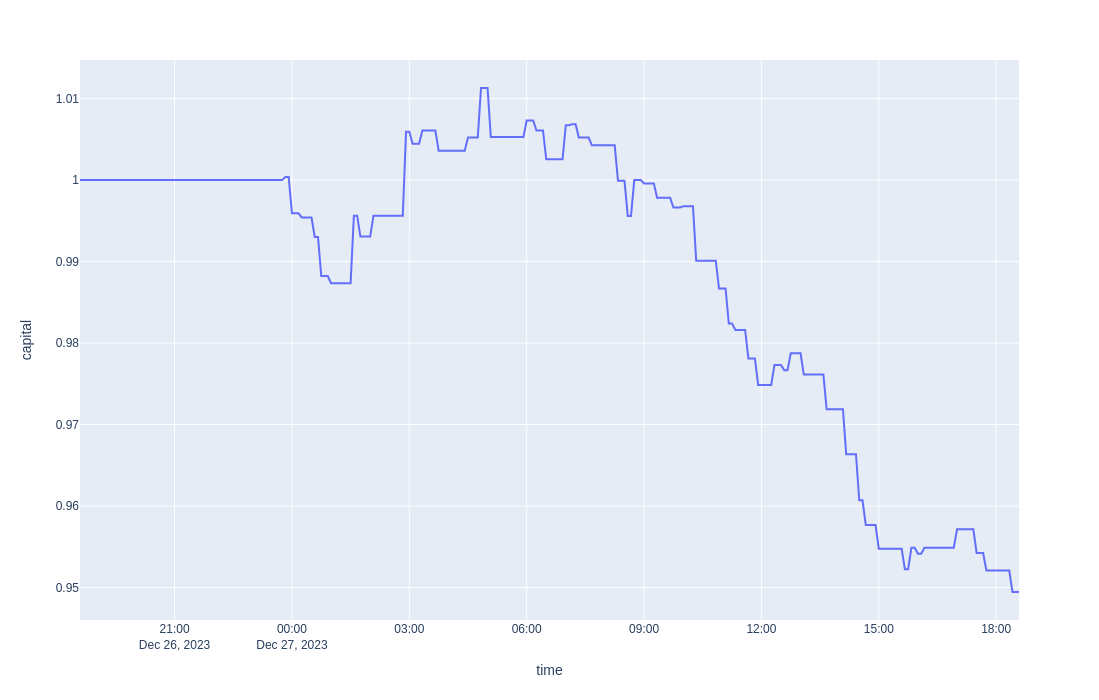

In [42]:
capital = 1
df['capital'] = 0
df_len = df.shape[0]
capital_ls = []
price_in = None

for ix in range(0, df_len):
    if ix < df_len - 1:
        row = df.iloc[ix]
        next_row = df.iloc[ix + 1]
        best_ask = row['best_ask']
        
        if row['prediction'] == 1:
            if price_in == None:
                price_in = row['best_bid']
        else:
            if price_in:
                pnl = (price_in - best_ask) / price_in
                # alog.info((pnl, price_in, best_ask))
                capital = capital + (capital * pnl * (1 - 0.005))
                
            price_in = None
            
    #alog.info(capital)
    capital_ls.append(capital)

df['capital'] = np.asarray(capital_ls)
print(df)
px.line(df, y='capital', height=700)